In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

import sqlite3
import sys
import time
import tqdm
from tqdm.auto import tqdm
import pickle
import joblib
import os

if os.path.exists('/workspace/data'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data/'
else:
    data_path = '../data/'


## Loading SQLite Database into Pandas DataFrames

The following code connects to an SQLite database (`melee_player_database.db`) and converts each table within the database into a pandas DataFrame. The DataFrames will be stored in a dictionary, where each key corresponds to the table name with `_df` appended, and the values are the respective DataFrames.

### Steps:

1. **Database Connection**: We use the `sqlite3` library to connect to the SQLite database file.
2. **Retrieve Table Names**: A query retrieves all the table names in the database.
3. **Convert Tables to DataFrames**: For each table:
   - The table is loaded into a pandas DataFrame using `pd.read_sql()`.
   - We check each column to see if any data is JSON-formatted (lists or dictionaries). If so, we convert these columns from strings into their corresponding Python objects using `json.loads()`.
4. **Store DataFrames**: The DataFrames are stored in a dictionary, where the key is the table name with a `_df` suffix, and the value is the DataFrame.
5. **Database Connection Closed**: Once all tables are loaded into DataFrames, the database connection is closed.

### Example:
If the database contains a table named `players`, the corresponding DataFrame will be stored in the dictionary with the key `players_df`, and can be accessed as:

```python
players_df = dfs['players_df']


In [63]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

if os.path.exists(data_path + 'dfs_dict.pkl'):
    cell_has_run = True
    # Load the dictionary of DataFrames from the pickle
    with open(data_path + 'dfs_dict.pkl', 'rb') as f:
        dfs = pickle.load(f)
# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = + data_path + "melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

### Here we adjust the data types of the dataframes so that they are the correct type. (This will be updated as needed.)

In [64]:
dfs['sets_df']['best_of'] = dfs['sets_df']['best_of'].fillna(0).astype(int) 

In [65]:
# # Save the dictionary of DataFrames as a pickle
# with open(data_path + 'dfs_dict.pkl', 'wb') as f:
#     pickle.dump(dfs, f)

### Here we make dataframes that we will use and print the head.

The integers in 'characters' count the number of games the player has played that character. (We verify this for Zain below.)

In [66]:
players_df = dfs['players_df']
players_df.head()


,game,player_id,tag,all_tags,prefixes,social,country,state,region,c_country,c_state,c_region,placings,characters,alias
0,melee,Rishi,Rishi,[Rishi],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
1,melee,15634,lloD,"[lloD, VGz | lloD, Llod]",[],{'twitter': ['lloD74']},United States,VA,,US,CA,Laurel,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/peach': 1089, 'melee/falco': 1, 'melee...",None
2,melee,6126,Zain,"[Zain, DontTestMe]",[PG],{'twitter': ['PG_Zain']},United States,VA,,US,CA,Los Angeles,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/marth': 1065, 'melee/pichu': 1, 'melee...",DontTestMe
3,melee,Chu,Chu,[Chu],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
4,melee,5620,Junebug,"[Junebug, LS | VGz Junebug]",[],{'twitter': ['arJunebug']},United States,VA,,US,VA,Richmond,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/sheik': 46, 'melee/falco': 4, 'melee/g...",None


In [67]:
ranking_df = dfs['ranking_df']
ranking_df.head()

,game,ranking_name,priority,region,seasons,tournaments,icon
0,melee,SSBMRank,0,world,"[2015, 2016, 2017, 2018, 2019]",[],miom


In [68]:
ranking_seasons_df = dfs['ranking_seasons_df']
ranking_seasons_df.head()

,game,ranking_name,season,start,end,total,by_id,by_placing,final,name
0,melee,SSBMRank,2015,1420070400,1451606399,100,"{'6189': 1, '1004': 2, '4465': 3, '1000': 4, '...","{'1': '6189', '2': '1004', '3': '4465', '4': '...",0,None
1,melee,SSBMRank,2016,1451606400,1483228799,100,"{'6189': 1, '1004': 2, '1000': 3, '1003': 4, '...","{'1': '6189', '2': '1004', '3': '1000', '4': '...",0,None
2,melee,SSBMRank,2017,1483228800,1514764799,100,"{'1004': 1, '6189': 2, '1000': 3, '1003': 4, '...","{'1': '1004', '2': '6189', '3': '1000', '4': '...",0,None
3,melee,SSBMRank,2018,1514793600,1546329600,100,"{'1004': 1, '6189': 2, '4465': 3, '15990': 4, ...","{'1': '1004', '2': '6189', '3': '4465', '4': '...",0,None
4,melee,SSBMRank,2019,1546329600,1577836800,100,"{'1004': 1, '4465': 2, '1000': 3, '16342': 4, ...","{'1': '1004', '2': '4465', '3': '1000', '4': '...",0,None


In [69]:
sets_df = dfs['sets_df']
print(f"{sets_df[sets_df['game_data'].apply(lambda x: len(x) > 0)].shape[0] / sets_df.shape[0]:0.01%} percent of sets have some game data")
sets_df.shape



32.9% percent of sets have some game data


(1795681, 14)

In [82]:
tournament_info_df = dfs['tournament_info_df']
print(tournament_info_df.shape)
tournament_info_df.head()


(39675, 20)


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,US,MI,Ann Arbor,92,[],{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0


## Overall Glicko-2 Exploration ##


Import weekly updated Glicko-2 rating.

In [71]:
player_ratings_df = pd.read_pickle(data_path + 'overall_players_ranking_new_weekly.pkl')
print(player_ratings_df.shape)
player_ratings_df.head()

(515, 96524)


,3612758,181699,340266,629311,410076,742562,15095,1105962,2387953,2772668,...,3130307,2702567,2986921,jBomb,Adderall Admiral,1565080,2620119,2155545,2971127,130638
2015-01-01,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-08,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-15,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-22,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1252.681917,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2015-01-29,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1252.681917,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


## Number of Glicko-2 updates
Running total of number of updates to each players glicko-2 rating. We use numba njit and prange to speed up the loops in the function. We save the results so that we only need to run the calculation once.

In [72]:
def previous_updates(array):
    """ This funcion returns an array like array with the number of times the value above i,j entry of array has changed.
    Args:
        array (np): the array

    Returns:
        np: the number of times array has changed above the i,j entry
    """
    previous_updates = np.zeros_like(array, dtype=np.int32)
    
    for i in range(1, array.shape[0]-1): # row i
        previous_row = array[i-1,:]
        # print(previous_row)
        current_row = array[i,:]
        # print(current_row)
        change = (previous_row != current_row).astype(np.int32)
        change

        previous_updates[i+1,:] = previous_updates[i,:] + change

    return previous_updates

## Testing array
# array = np.array([
#     [1, 1, 1],
#     [1, 1, 2],
#     [1, 2, 3],
#     [1, 3, 4]])

# print(array)
# previous_updates(array)
# print(previous_updates(array))

# # Do the calculation once.
# player_ratings_np = player_ratings_df.to_numpy()
# start = time.time()
# number_of_rating_updates_df = pd.DataFrame(columns=player_ratings_df.columns, index=player_ratings_df.index, data=previous_updates(player_ratings_np))
# end = time.time()
# print(f'time = {end-start:.2f}')
# number_of_rating_updates_df.head()

# # Save the results
# number_of_rating_updates_df.to_pickle(data_path + 'number_of_rating_updates_df.pkl')

## Load the results
number_of_rating_updates_df = pd.read_pickle(data_path + 'number_of_rating_updates_df.pkl')
number_of_rating_updates_df.head()

,3612758,181699,340266,629311,410076,742562,15095,1105962,2387953,2772668,...,3130307,2702567,2986921,jBomb,Adderall Admiral,1565080,2620119,2155545,2971127,130638
2015-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Add some columns to sets_df
We add the start of the tournament, the player ratings at the start of the tournament, and the number of times the player's rating has been updated before the start of the tournament.

In [73]:
# Perform a merge on 'key' and 'tournament_key' to bring 'start' dates into sets_df
merged_df = sets_df.merge(tournament_info_df[['key', 'start']], left_on='tournament_key', right_on='key', how='left')


In [81]:
tqdm.pandas()
import swifter

# Function to get both Player 1 and Player 2 ratings and the number of rating updates
def get_ratings_and_updates(row, player_ratings_df, number_of_rating_updates_df):
    # Find the closest date in player_ratings_df that is <= 'start' date
    closest_date = player_ratings_df.index[player_ratings_df.index <= row['start']].max()
    
    # If there's no valid date, return None for ratings and updates
    if pd.isnull(closest_date):
        return pd.Series([None, None, None, None], index=['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates'])
    
    # Fetch Player 1's and Player 2's ratings on the closest date
    p1_rating = player_ratings_df.loc[closest_date, row['p1_id']] if row['p1_id'] in player_ratings_df.columns else None
    p2_rating = player_ratings_df.loc[closest_date, row['p2_id']] if row['p2_id'] in player_ratings_df.columns else None
    
    # Fetch Player 1's and Player 2's number of rating updates on the closest date
    p1_updates = number_of_rating_updates_df.loc[closest_date, row['p1_id']] if row['p1_id'] in number_of_rating_updates_df.columns else None
    p2_updates = number_of_rating_updates_df.loc[closest_date, row['p2_id']] if row['p2_id'] in number_of_rating_updates_df.columns else None
    
    # Return all values as a pandas Series
    return pd.Series([p1_rating, p2_rating, p1_updates, p2_updates], 
                     index=['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates'])

# Apply the function to each row in merged_df
merged_df[['p1_rating', 'p2_rating', 'p1_updates', 'p2_updates']] = merged_df.swifter.apply(
    get_ratings_and_updates, axis=1, 
    player_ratings_df=player_ratings_df, 
    number_of_rating_updates_df=number_of_rating_updates_df,
)

# Save
merged_df.to_pickle(data_path + 'augmented_sets_df.pkl')

# # Load
augmented_sets_df = pd.read_pickle(data_path + 'augmented_sets_df.pkl')
augmented_sets_df.head()

Pandas Apply:   0%|          | 0/1795681 [00:00<?, ?it/s]

,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,5620,Chillin,3,1,"[R1, Round 1, Round 1]",,1,A,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1995.568005,1500.000000,10.0,0.0
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,2,3,"[R1, Round 1, Round 1]",,1,B,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2094.642998,1500.000000,10.0,0.0
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,6126,1097,3,0,"[R1, Round 1, Round 1]",,1,C,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,2105.536004,1960.602597,13.0,11.0
3,104675846,melee,mdva-invitational-2017-(challonge-mirror),1069,Chu,1069,0,3,"[R1, Round 1, Round 1]",,1,D,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1500.000000,1910.424390,0.0,14.0
4,104675847,melee,mdva-invitational-2017-(challonge-mirror),Rishi,Jerry,Rishi,1,3,"[R1, Round 1, Round 1]",,1,E,5,[],mdva-invitational-2017-(challonge-mirror),2017-11-26 08:05:11,1500.000000,1500.000000,0.0,0.0


## Top 8 Locations
Here we look for what the sets corresponding to the top 8 of a tournament are labeled as in the column 'location_names'. We do this by inspection.

In [76]:
print(sets_df['location_names'].value_counts().to_string())

location_names
[W1, Winners 1, Winners Round 1]                                                              218928
[L2, Losers 2, Losers Round 2]                                                                178053
[W2, Winners 2, Winners Round 2]                                                              176575
[WQF, Winners Quarters, Winners Quarter-Final]                                                171715
[L1, Losers 1, Losers Round 1]                                                                163507
[L3, Losers 3, Losers Round 3]                                                                111521
[WSF, Winners Semis, Winners Semi-Final]                                                       89587
[LQF, Losers Quarters, Losers Quarter-Final]                                                   83806
[R1, Round 1, Round 1]                                                                         60476
[R2, Round 2, Round 2]                                                      

Get all top 8 sets.

In [77]:
# The vast majority of the top 8 games have these "location_names"
top_8_locations = [
        ['WQF', 'Winners Quarters', 'Winners Quarter-Final'],                                   
        ['WSF', 'Winners Semis', 'Winners Semi-Final'],
        ['LQF', 'Losers Quarters', 'Losers Quarter-Final'],
        ['WF', 'Winners Final', 'Winners Final'],
        ['LSF', 'Losers Semis', 'Losers Semi-Final'],
        ['LF', 'Losers Final', 'Losers Final'],
        ['GF', 'Grand Final', 'Grand Final'],
        ['GFR', 'GF Reset', 'Grand Final Reset']
    ] 

top_8_sets_df = augmented_sets_df[augmented_sets_df["location_names"].isin(top_8_locations)]
top_8_tournament_keys = top_8_sets_df['tournament_key'].unique()
print(f"There are {len(top_8_tournament_keys)} tournaments with double elimination finals.")
top_8_sets_df.head()

There are 36279 tournaments with double elimination finals.


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start
129,90101112,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),i4n,1,0,"[WQF, Winners Quarters, Winners Quarter-Final]",,1,CG,0,[],s@sh7,2017-06-13 10:27:01
130,90101113,melee,s@sh7,kjh,kjh,tm,1,0,"[WQF, Winners Quarters, Winners Quarter-Final]",,1,CH,0,[],s@sh7,2017-06-13 10:27:01
131,90101114,melee,s@sh7,1008,1008,Mingee,1,0,"[WQF, Winners Quarters, Winners Quarter-Final]",,1,CI,0,[],s@sh7,2017-06-13 10:27:01
132,90101115,melee,s@sh7,Ginger,Ginger,3402,1,0,"[WQF, Winners Quarters, Winners Quarter-Final]",,1,CJ,0,[],s@sh7,2017-06-13 10:27:01
133,90101116,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),kjh,1,0,"[WSF, Winners Semis, Winners Semi-Final]",,1,CK,0,[],s@sh7,2017-06-13 10:27:01


Restrict our data set to tournaments that have the double elimination format.

In [78]:
tournament_sets_with_top_8_df = augmented_sets_df[augmented_sets_df['tournament_key'].isin(top_8_tournament_keys)]
non_top_8_sets_df = tournament_sets_with_top_8_df[~ tournament_sets_with_top_8_df['location_names'].isin(top_8_locations)]
non_top_8_sets_df.head()

,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,1,A,0,[],s@sh7,2017-06-13 10:27:01
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,1,B,0,[],s@sh7,2017-06-13 10:27:01
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,1,C,0,[],s@sh7,2017-06-13 10:27:01
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,1,D,0,[],s@sh7,2017-06-13 10:27:01
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,1,E,0,[],s@sh7,2017-06-13 10:27:01


In [79]:
# Flatten the top_8_locations to a single list of all location name variations
top_8_flat_list = [location for sublist in top_8_locations for location in sublist]

# Add a 'top_8' column based on whether 'location_names' matches any entry in the top_8_flat_list
tournament_sets_with_top_8_df.loc[:,'top_8'] = tournament_sets_with_top_8_df['location_names'].apply(
    lambda locations: any(location in top_8_flat_list for location in locations)
)

tournament_sets_with_top_8_df.head()

/tmp/ipykernel_194827/1419768670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tournament_sets_with_top_8_df.loc[:,'top_8'] = tournament_sets_with_top_8_df['location_names'].apply(


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,top_8
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,1,A,0,[],s@sh7,2017-06-13 10:27:01,False
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,1,B,0,[],s@sh7,2017-06-13 10:27:01,False
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,1,C,0,[],s@sh7,2017-06-13 10:27:01,False
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,1,D,0,[],s@sh7,2017-06-13 10:27:01,False
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,1,E,0,[],s@sh7,2017-06-13 10:27:01,False


In [80]:
tournament_sets_with_top_8_df.groupby('top_8')['p1_rating'].describe()

KeyError: 'Column not found: p1_rating'

In [20]:
tournament_sets_with_top_8_df.groupby('top_8')['p2_rating'].describe()



,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1382727.0,1431.938616,233.703490,500.0,1279.684703,1469.547591,1553.225299,3532.230236
True,332655.0,1632.923001,252.434367,500.0,1488.026215,1623.364676,1800.585047,3532.230236


In [21]:
tournament_sets_with_top_8_df.groupby('top_8')['p1_updates'].describe()

,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1382731.0,30.045156,32.989780,0.0,5.0,19.0,44.0,235.0
True,332655.0,41.949518,38.146774,0.0,12.0,31.0,63.0,235.0


In [22]:
tournament_sets_with_top_8_df.groupby('top_8')['p2_updates'].describe()

,count,mean,std,min,25%,50%,75%,max
top_8,,,,,,,,
False,1382727.0,19.914588,25.547003,0.0,2.0,10.0,28.0,235.0
True,332655.0,34.943383,34.325000,0.0,8.0,25.0,52.0,234.0


Add a column with the absolute rating difference.

In [23]:
tournament_sets_with_top_8_df['rating_difference'] = np.abs(tournament_sets_with_top_8_df['p1_rating'] - tournament_sets_with_top_8_df['p2_rating'])
tournament_sets_with_top_8_df.head()


/tmp/ipykernel_194827/3408073964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tournament_sets_with_top_8_df['rating_difference'] = np.abs(tournament_sets_with_top_8_df['p1_rating'] - tournament_sets_with_top_8_df['p2_rating'])


,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,...,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates,top_8,rating_difference
45,90101028,melee,s@sh7,Fija,Fija,Sasha,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1667.529088,1500.00000,1.0,0.0,False,167.529088
46,90101029,melee,s@sh7,Don Juan,Don Juan,absynthe,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False,0.000000
47,90101030,melee,s@sh7,Bird,Empty Spirits,Bird,0,1,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1622.33761,0.0,2.0,False,122.337610
48,90101031,melee,s@sh7,Stitchface,3551,Stitchface,0,1,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1523.497940,1500.00000,3.0,0.0,False,23.497940
49,90101032,melee,s@sh7,Pham,Pham,Juicebox,1,0,"[W1, Winners 1, Winners Round 1]",,...,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.00000,0.0,0.0,False,0.000000


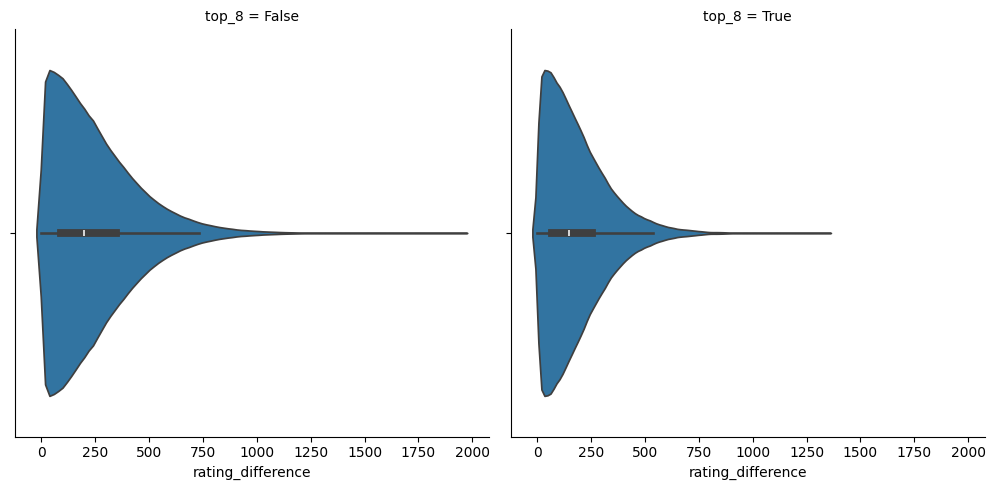

In [24]:
sns.catplot(data=tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['rating_difference'] > 0], x='rating_difference', col='top_8', kind='violin')
plt.show()

In [25]:
# Make a deep copy of the dataframe to avoid the warning
tournament_sets_with_top_8_df = tournament_sets_with_top_8_df.copy()
tournament_sets_with_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['rating_difference'] > 1]

# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['higher_rated_won'] = (
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) & 
     (tournament_sets_with_top_8_df['p1_rating'] > tournament_sets_with_top_8_df['p2_rating'])) |
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p2_id']) & 
     (tournament_sets_with_top_8_df['p2_rating'] > tournament_sets_with_top_8_df['p1_rating']))
)
print(tournament_sets_with_top_8_df.shape)
# tournament_sets_with_top_8_df.info()

(1657512, 23)


In [26]:
print(f"Overall rating baseline: {tournament_sets_with_top_8_df['higher_rated_won'].sum() / tournament_sets_with_top_8_df.shape[0]:.2%}")

top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == True]
print(f"Top 8 rating baseline: {top_8_df['higher_rated_won'].sum() / top_8_df.shape[0]:.2%}")
non_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == False]
print(f"Non top 8 rating baseline: {non_top_8_df['higher_rated_won'].sum() / non_top_8_df.shape[0]:.2%}")


Overall rating baseline: 75.02%
Top 8 rating baseline: 73.58%
Non top 8 rating baseline: 75.37%


In [27]:
# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['more_updates_won'] = (
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) & 
     (tournament_sets_with_top_8_df['p1_updates'] > tournament_sets_with_top_8_df['p2_updates'])) |
    ((tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p2_id']) & 
     (tournament_sets_with_top_8_df['p2_updates'] > tournament_sets_with_top_8_df['p1_updates']))
)

In [28]:
top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == True]
print(f"Top 8 updates baseline: {top_8_df['more_updates_won'].sum() / top_8_df.shape[0]:.0%}")
non_top_8_df = tournament_sets_with_top_8_df[tournament_sets_with_top_8_df['top_8'] == False]
print(f"Non top 8 updates baseline: {non_top_8_df['more_updates_won'].sum() / non_top_8_df.shape[0]:.0%}")

Top 8 updates baseline: 58%
Non top 8 updates baseline: 64%


In [29]:
# Now safely create the 'higher_rated_won' column
tournament_sets_with_top_8_df['p1_won'] = (tournament_sets_with_top_8_df['winner_id'] == tournament_sets_with_top_8_df['p1_id']) 



In [30]:
print(f"Player 1 won {tournament_sets_with_top_8_df['p1_won'].sum() / tournament_sets_with_top_8_df.shape[0]:.1%} of the time.")

Player 1 won 70.4% of the time.


In [31]:
tournament_sets_with_top_8_df.to_pickle(data_path + 'tournament_sets_with_top_8_df.pkl')

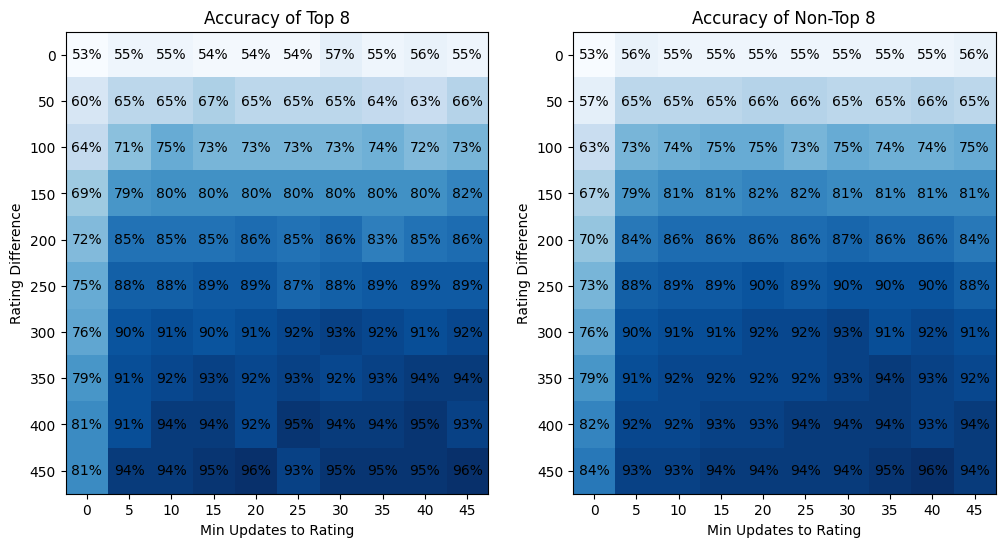

In [32]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p2_updates'], top_8_df['p1_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range


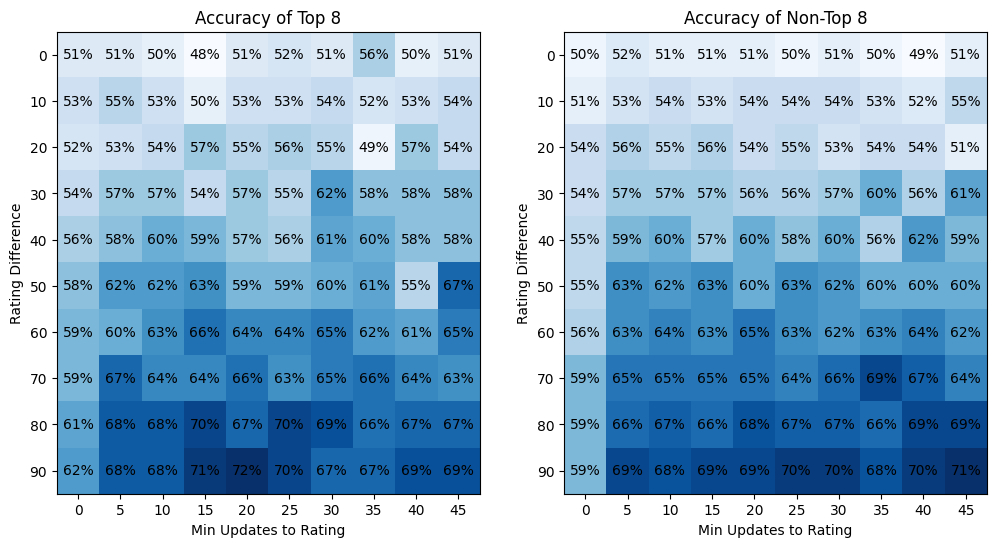

In [33]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range

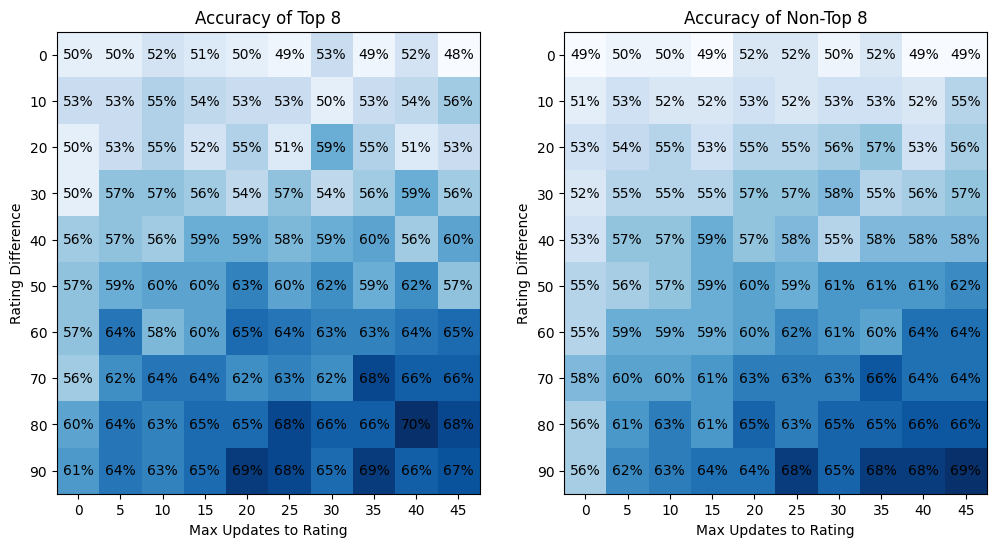

In [34]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask]['higher_rated_won'].sum() / masked_top_8[difference_mask].shape[0] * 100)

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask]['higher_rated_won'].sum() / masked_non_top_8[difference_mask].shape[0] * 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Accuracy of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}%', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Accuracy of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}%', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range

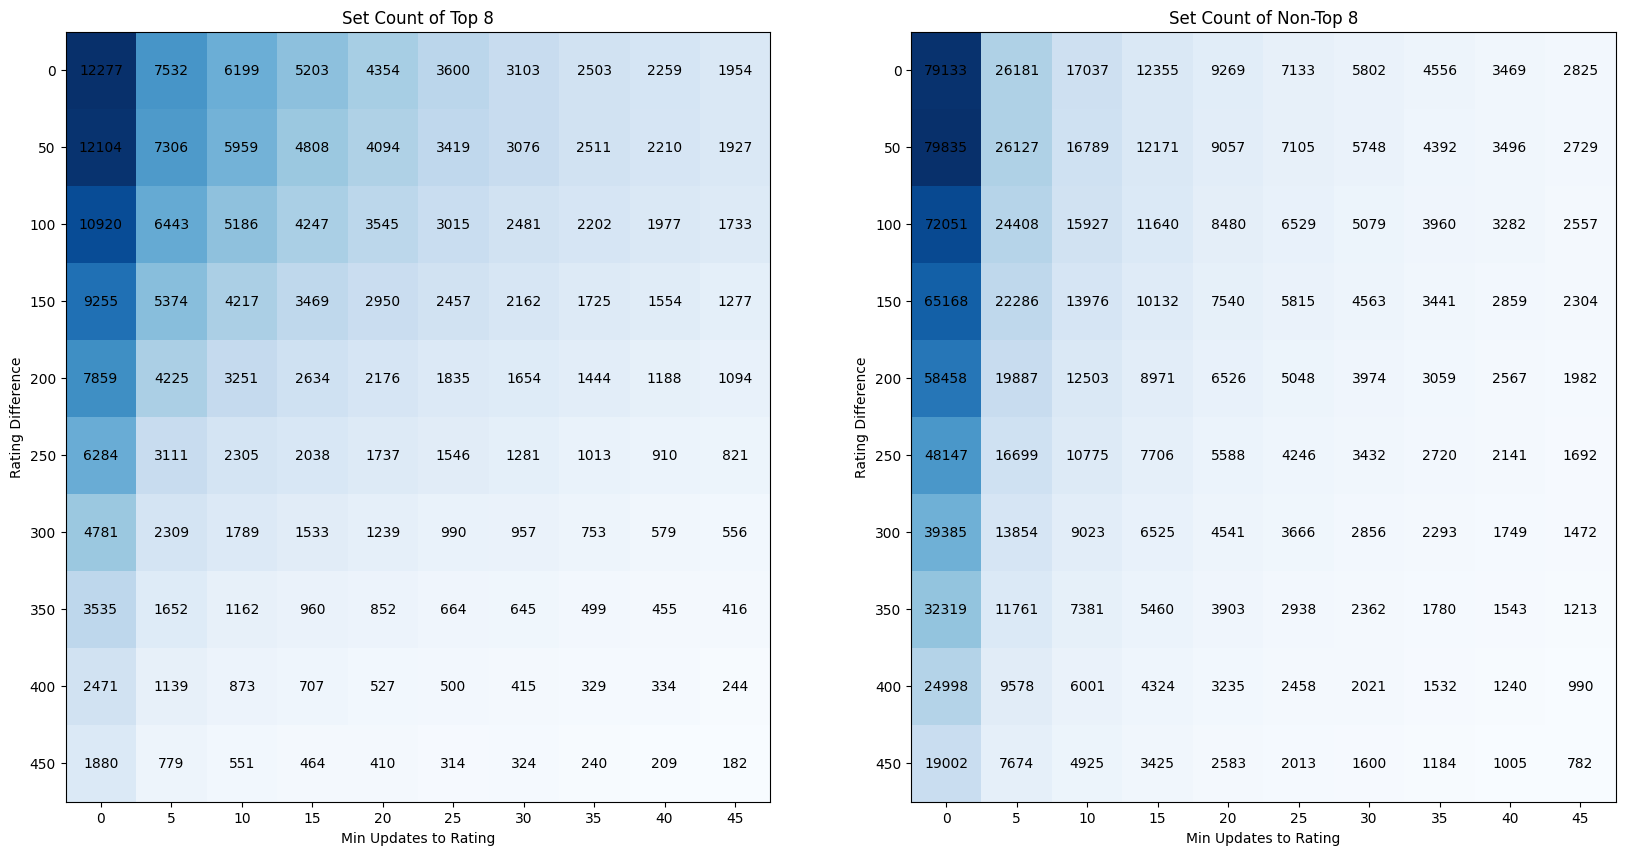

In [35]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.minimum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.minimum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Min Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range


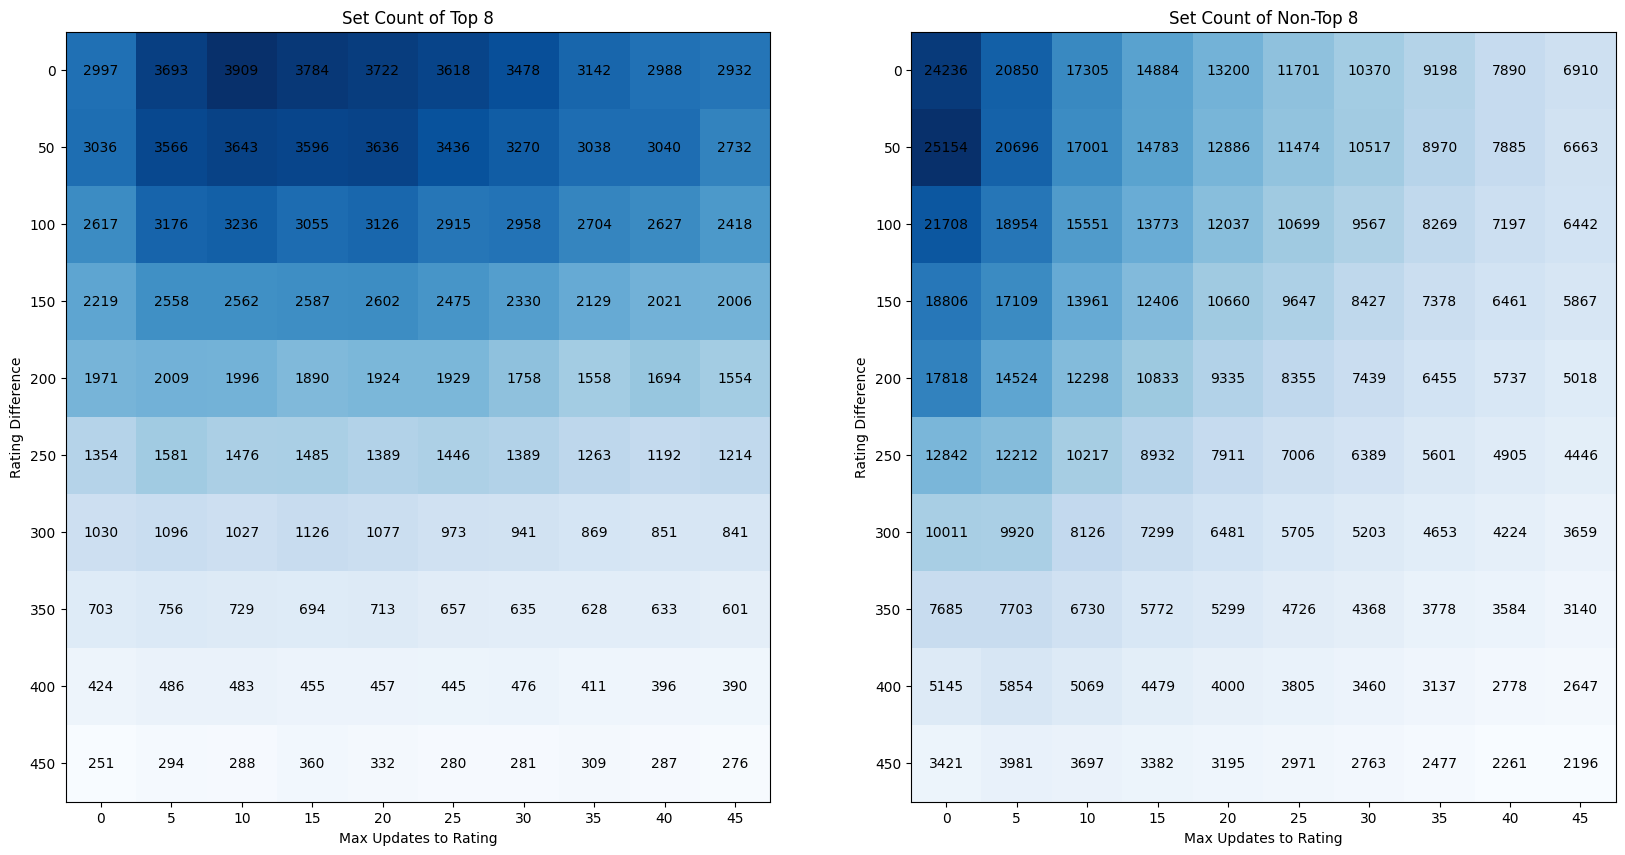

In [36]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 50)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,500, 50)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 50)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 500, 50))  # Matches your `rating_difference` range

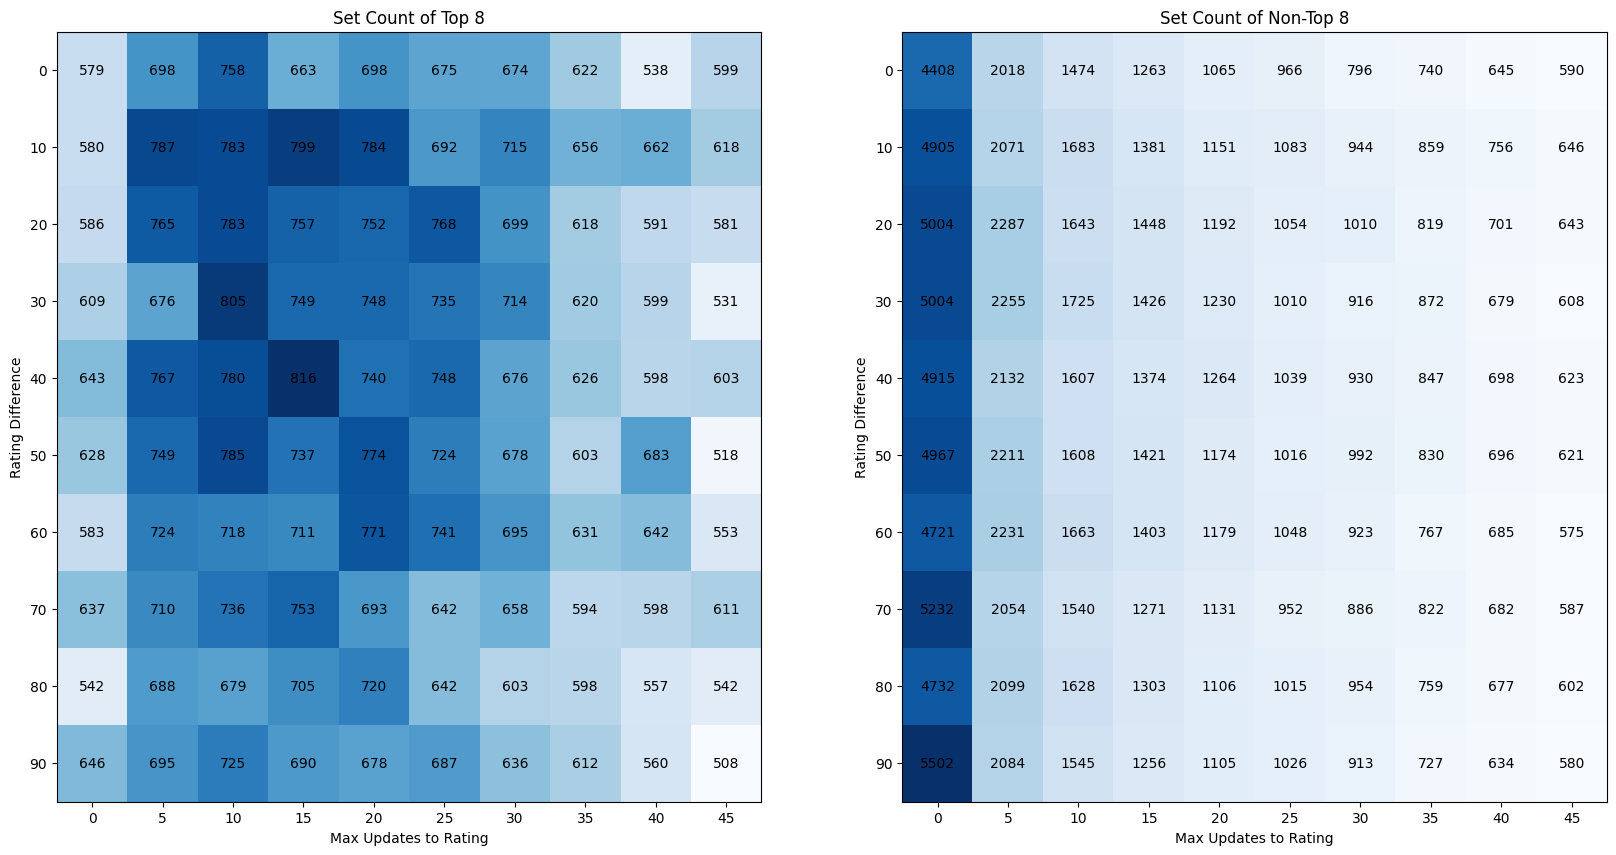

In [37]:
accuracy_of_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) >= updates) & (np.maximum(top_8_df['p1_updates'], top_8_df['p2_updates']) < updates + 5)
    masked_top_8 = top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_top_8['rating_difference'] >= difference) & (masked_top_8['rating_difference'] < difference + 10)
        accuracy_of_top_8[j,i] = int(masked_top_8[difference_mask].shape[0])

accuracy_of_non_top_8 = np.zeros((10,10), dtype=np.int32)

for i, updates in enumerate(range(0, 50, 5)):
    updates_mask = (np.maximum(non_top_8_df['p2_updates'], non_top_8_df['p2_updates']) >= updates) & (np.maximum(non_top_8_df['p1_updates'], non_top_8_df['p2_updates']) < updates + 5)
    masked_non_top_8 = non_top_8_df[updates_mask]
    for j, difference in enumerate(range(0,100, 10)):
        difference_mask = (masked_non_top_8['rating_difference'] >= difference) & (masked_non_top_8['rating_difference'] < difference + 10)
        accuracy_of_non_top_8[j,i] = int(masked_non_top_8[difference_mask].shape[0])


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for top 8
cax1 = axs[0].imshow(accuracy_of_top_8, cmap='Blues', aspect='auto')
axs[0].set_title('Set Count of Top 8')

# Annotating values in the cells for top 8
for i in range(accuracy_of_top_8.shape[0]):
    for j in range(accuracy_of_top_8.shape[1]):
        axs[0].text(j, i, f'{accuracy_of_top_8[i, j]}', ha='center', va='center', color='black')

# Heatmap for non-top 8
cax2 = axs[1].imshow(accuracy_of_non_top_8, cmap='Blues', aspect='auto')
axs[1].set_title('Set Count of Non-Top 8')

# Annotating values in the cells for non-top 8
for i in range(accuracy_of_non_top_8.shape[0]):
    for j in range(accuracy_of_non_top_8.shape[1]):
        axs[1].text(j, i, f'{accuracy_of_non_top_8[i, j]}', ha='center', va='center', color='black')

# Set labels and ticks for both heatmaps
for ax in axs:
    ax.set_xlabel('Max Updates to Rating')  # This is correct for the y-axis
    ax.set_ylabel('Rating Difference')  # This should be the x-axis label
    ax.set_xticks(np.arange(0, 10))  # These ticks are fine
    ax.set_yticks(np.arange(0, 10))  # These ticks are fine
    ax.set_xticklabels(np.arange(0, 50, 5))  # Matches your `updates` range
    ax.set_yticklabels(np.arange(0, 100, 10))  # Matches your `rating_difference` range


## Highest Ranked Player Wins Tournament


In [38]:
len(top_8_tournament_keys)

36183

In [39]:
tournaments_with_top_8_df = tournament_info_df[tournament_info_df['key'].isin(top_8_tournament_keys)]
print(tournaments_with_top_8_df.head(3))

     game                                            key  \
1   melee                                          s@sh7   
11  melee  httpsparagonchallongecomla_2015_melee_singles   
12  melee      httpsdl4-5challongecomdl45meleeprobracket   

                cleaned_name     source  \
1                      S@SH7  challonge   
11  Paragon Los Angeles 2015  challonge   
12              DrommeLAN4.5  challonge   

                                      tournament_name tournament_event season  \
1                         https://challonge.com/sash7                      17   
11  https://paragon.challonge.com/la_2015_melee_si...                      15   
12    https://dl4-5.challonge.com/DL45meleeProBracket                      15   

   rank               start                 end country state       city  \
1       2017-06-13 10:27:01 2017-06-13 10:27:01      US    MI  Ann Arbor   
11      2015-09-06 23:45:46 2015-09-07 20:33:07    None  None       None   
12      2015-05-02 23:55:20 2015-

In [40]:
print(type(tournaments_with_top_8_df['placings'].iloc[4]))
tournaments_with_top_8_df['placings'].head(10)

<class 'list'>


1                                                    []
11    [[1000, 1], [Azen Zagenite, 49], [1032, 17], [...
12    [[6189, 1], [4465, 2], [12870, 4], [6103, 3], ...
13    [[1000, 3], [6189, 2], [4465, 1], [19573, 4], ...
14    [[1004, 1], [4465, 3], [1003, 2], [6189, 5], [...
15    [[1000, 4], [6189, 2], [1002, 1], [1003, 9], [...
16    [[6189, 1], [1000, 5], [4465, 5], [1004, 4], [...
17    [[1000, 1], [1004, 4], [1036, 9], [1003, 7], [...
18    [[1004, 1], [1007, 2], [1022, 3], [1024, 4], [...
19    [[1003, 1], [15990, 2], [1028, 3], [1027, 5], ...
Name: placings, dtype: object

In [41]:
print(tournaments_with_top_8_df['placings'].iloc[4])

[[1004, 1], [4465, 3], [1003, 2], [6189, 5], [4721, 17], [1077, 17], ['dizzkidboogie', 33], [1083, 17], ['Elliot', 33], ['EE | uuaa', 33], ['Pi', 25], ['SS | Flow', 33], [1036, 13], [1041, 13], [1028, 13], [1024, 9], [1068, 17], [1063, 17], [1089, 25], [1052, 33], [1019, 9], [16342, 7], [1008, 4], [13932, 9], [1020, 13], [15990, 5], [1013, 7], [1009, 9], ['Harriet', 33], ['Drugged Fox', 17], ['SS | PB&J', 49], ['awstintacious', 33], ['Fearless', 49], ['BluEG', 33], ['Prof', 33], ['H&V VS | Spider_Sense', 17], ['Mushroom Dynamite!', 33], ['BigWenz', 49], ['VGBC | GimR', 49], ['Smilez=)', 25], ['Apollo', 49], ['Envy', 49], ['GK | EikelmannRUS', 25], ['Christian', 33], ['Sartron', 49], ['Rula', 49], ['moe | Upke', 33], ['Moltov', 49], ['Deez', 33], ['mordicon', 49], ['MELEE HELL | Articanus', 25], ['Rice', 33], ['The Author', 49], ['jBomb', 49], ['SS | SmashMac', 17], [14436, 25], ['FlyingPikachu', 49], ['SS | KeepSpeedN', 33], ['RockCrock', 33], ['BlueJim', 49], ['JRad', 49], ['Paz', 49]

In [42]:
import pandas as pd

# Define a function to extract the top 3 player IDs from the 'placings' list, handling None values
def extract_top_3(placings):
    # Check if placings is None or an empty list
    if placings is None or len(placings) == 0:
        return pd.Series([None, None, None], index=['1', '2', '3'])
    
    # Filter out invalid entries (ensure they are lists of length 2 with valid player_id and rank)
    valid_placings = [p for p in placings if isinstance(p, list) and len(p) == 2 and isinstance(p[1], int)]
    
    # Sort the valid placings based on the rank (second element in each sublist)
    sorted_placings = sorted(valid_placings, key=lambda x: x[1])
    
    # Extract the player IDs of the top 3 (if available)
    top_3 = [p[0] for p in sorted_placings[:3]]
    
    # If there are less than 3 players, fill the remaining spots with None
    while len(top_3) < 3:
        top_3.append(None)
    
    return pd.Series(top_3, index=['1', '2', '3'])

# Apply the function to extract top 3 players to the 'placings' column
top_3_df = tournaments_with_top_8_df[['key', 'placings']].copy()
top_3_df[['1', '2', '3']] = top_3_df['placings'].apply(extract_top_3)

# Drop the 'placings' column, as we only need the 'key' and top 3 player IDs
top_3_df = top_3_df.drop(columns=['placings'])

# Display the resulting DataFrame
top_3_df.head()


,key,1,2,3
1,s@sh7,None,None,None
11,httpsparagonchallongecomla_2015_melee_singles,1000,1003,1004
12,httpsdl4-5challongecomdl45meleeprobracket,6189,4465,6103
13,httpsbeastsmashchallongecomb5msb,4465,6189,1000
14,httpsparagonchallongecomorlando_2015_melee_sin...,1004,1003,4465


In [46]:
top_8_sets_df.head(16)

,key_x,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data,key_y,start,p1_rating,p2_rating,p1_updates,p2_updates
133,90101116,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),kjh,1,0,"[WSF, Winners Semis, Winners Semi-Final]",,1,CK,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.000000,0.0,0.0
134,90101117,melee,s@sh7,Ginger,1008,Ginger,0,1,"[WSF, Winners Semis, Winners Semi-Final]",,1,CL,0,[],s@sh7,2017-06-13 10:27:01,2059.466548,1643.796527,43.0,1.0
135,90101118,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),Ginger,1,0,"[WF, Winners Final, Winners Final]",,1,CM,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1643.796527,0.0,1.0
222,90101205,melee,s@sh7,1008,1008,tm,1,0,"[LQF, Losers Quarters, Losers Quarter-Final]",,1,FX,0,[],s@sh7,2017-06-13 10:27:01,2059.466548,1669.343857,43.0,1.0
223,90101206,melee,s@sh7,kjh,kjh,lain,1,0,"[LQF, Losers Quarters, Losers Quarter-Final]",,1,FY,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.000000,0.0,0.0
224,90101207,melee,s@sh7,kjh,1008,kjh,0,1,"[LSF, Losers Semis, Losers Semi-Final]",,1,FZ,0,[],s@sh7,2017-06-13 10:27:01,2059.466548,1500.000000,43.0,0.0
225,90101208,melee,s@sh7,kjh,Ginger,kjh,0,1,"[LF, Losers Final, Losers Final]",,1,GA,0,[],s@sh7,2017-06-13 10:27:01,1643.796527,1500.000000,1.0,0.0
226,90101209,melee,s@sh7,Mew2king (unpaid),Mew2king (unpaid),kjh,1,0,"[GF, Grand Final, Grand Final]",,1,CN,0,[],s@sh7,2017-06-13 10:27:01,1500.000000,1500.000000,0.0,0.0
489,,melee,httpsparagonchallongecomla_2015_melee_singles,1000,1000,16342,3,1,"[WSF, Winners Semis, Winners Semi-Final]",,1,BI,5,[],httpsparagonchallongecomla_2015_melee_singles,2015-09-06 23:45:46,1950.348732,1888.611974,6.0,6.0
490,,melee,httpsparagonchallongecomla_2015_melee_singles,1003,4465,1003,1,3,"[WSF, Winners Semis, Winners Semi-Final]",,1,BJ,5,[],httpsparagonchallongecomla_2015_melee_singles,2015-09-06 23:45:46,1964.348729,1876.719754,11.0,6.0


In [61]:
top_8_locations = [
        ['WSF', 'Winners Semis', 'Winners Semi-Final'],
        ['LQF', 'Losers Quarters', 'Losers Quarter-Final'],
        ['LSF', 'Losers Semis', 'Losers Semi-Final'],
        ['WF', 'Winners Final', 'Winners Final'],
        ['LF', 'Losers Final', 'Losers Final'],
        ['GF', 'Grand Final', 'Grand Final'],
        ['GFR', 'GF Reset', 'Grand Final Reset']
    ] 

KeyError: "Columns not found: 's@sh7'"